# Toxic Text Recognition 
by : Hesham Asem

________________

here we have a huge database with about 1.8 million sample size , which got a variety comments & texts , some of them are classified as offensive & toxic 

we need to build a model able to train from this database , so he can classify the test data

database  : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data


so let's import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from nltk.corpus import stopwords
from wordcloud import WordCloud
import collections
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile , f_classif 


then we'll read the data

In [2]:
data = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv' )  
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv' )  

and since the database is huge , we'll just got 10K rows from it to save time in training , but you can deactivate this line if you need to take the whole data

In [3]:
data = data[:10000]

____

now it's time to define needed functions


In [4]:
def unique(feature) : 
    global data
    print(f'Number of unique vaure are {len(list(data[feature].unique()))} which are : \n {list(data[feature].unique())}')

def count_nulls() : 
    global data
    for col in data.columns : 
        if not data[col].isna().sum() == 0 : 
            print(f'Column   {col}    got   {data[col].isna().sum()} nulls  ,  Percentage : {round(100*data[col].isna().sum()/data.shape[0])} %')

def cplot(feature) : 
    global data
    sns.countplot(x=feature, data=data,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))

def encoder(feature , new_feature, drop = True) : 
    global data
    enc  = LabelEncoder()
    enc.fit(data[feature])
    data[new_feature] = enc.transform(data[feature])
    if drop == True : 
        data.drop([feature],axis=1, inplace=True)
    
def MakeCloud(text , title = 'Word Clouds' , w = 15 , h = 15):
    plt.figure(figsize=(w,h))
    plt.imshow(WordCloud(background_color="white",stopwords=set(stopwords.words('english')))
               .generate(" ".join([i for i in text.str.lower()])))
    plt.axis("off")
    plt.title(title)
    plt.show()


def SelectedData(data , feature , value , operation, selected_feature ):
    if operation==0 : 
        result = data[data[feature]==value][selected_feature]
    elif operation==1 : 
        result = data[data[feature] > value][selected_feature]
    elif operation==2 : 
        result = data[data[feature]< value][selected_feature]
    
    return result 



def CommonWords(text ,show = True , kk=10) : 
    all_words = []

    for i in range(text.shape[0]) : 
        this_phrase = list(text)[i]
        for word in this_phrase.split() : 
            all_words.append(word)
    common_words = collections.Counter(all_words).most_common()
    k=0
    word_list =[]
    for word, i in common_words : 
        if not word.lower() in  nlp.Defaults.stop_words :
            if show : 
                print(f'The word is   {word}   repeated   {i}  times')
            word_list.append(word)
            k+=1
        if k==kk : 
            break
            
    return word_list

def RemoveWords(data , feature , new_feature, words_list ) : 
    new_column = []
    for i in range(data.shape[0]) : 
        this_phrase = data[feature][i]
        new_phrase = []
        for word in this_phrase.split() : 
            if not word.lower() in words_list : 
                new_phrase.append(word)
        new_column.append(' '.join(new_phrase))
    
    data.insert(data.shape[1],new_feature,new_column)
    

    
def CountWords(text) :  
    
    all_words = []

    for i in range(text.shape[0]) : 
        this_phrase = list(text)[i]
        for word in this_phrase.split() : 
            all_words.append(word)

    print(f'Total words are {len(all_words)} words')   
    print('')
    print(f'Total unique words are {len(set(all_words))} words')   

def SlicedData(feature_list, dropna = False) : 
    global data
    if dropna :
        return data.loc[:, feature_list ].dropna()
    else : 
        return data.loc[:, feature_list ]


____


# Data Processing

now how data looks like

In [5]:
data.shape

(10000, 45)

In [6]:
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [7]:
data.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,2176.000000,2176.000000,2176.000000,...,5134.000000,10000.000000,10000.000000,10000.0,10000.0,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000
mean,247306.714000,0.081725,0.003749,0.014624,0.016498,0.063065,0.007608,0.005146,0.008817,0.004559,...,247695.496104,42221.700400,0.000300,0.0,0.0,0.992500,0.0001,0.006553,1.700800,8.726800
std,6749.786368,0.175589,0.021206,0.074413,0.065322,0.153128,0.041393,0.051778,0.087368,0.048024,...,4089.309371,5813.156747,0.017319,0.0,0.0,1.565787,0.0100,0.046526,28.867882,52.754504
min,59848.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,229671.000000,2006.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,4.000000
25%,244122.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,244468.000000,38551.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,4.000000
50%,247677.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,248028.500000,42482.000000,0.000000,0.0,0.0,0.000000,0.0000,0.000000,0.000000,4.000000
75%,250752.500000,0.000166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,250729.250000,46566.000000,0.000000,0.0,0.0,1.000000,0.0000,0.000000,0.000000,6.000000
max,254561.000000,1.000000,0.300000,1.000000,0.833333,1.000000,0.719018,1.000000,1.000000,1.000000,...,254546.000000,51944.000000,1.000000,0.0,0.0,20.000000,1.0000,0.920308,1842.000000,1680.000000


______

so we need to have a close look to some features

In [8]:
SlicedData(['obscene','identity_attack', 'insult' , 'thread']).describe()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,obscene,identity_attack,insult,thread
count,10000.000000,10000.000000,10000.000000,0.0
mean,0.014624,0.016498,0.063065,NaN
std,0.074413,0.065322,0.153128,NaN
min,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.000000,0.000000,NaN
50%,0.000000,0.000000,0.000000,NaN
75%,0.000000,0.000000,0.000000,NaN
max,1.000000,0.833333,1.000000,NaN


In [9]:
SlicedData(['asian','atheist', 'bisexual' , 'black']).describe()

,asian,atheist,bisexual,black
count,2176.000000,2176.000000,2176.000000,2176.000000
mean,0.005146,0.008817,0.004559,0.044732
std,0.051778,0.087368,0.048024,0.187059
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


# Treating Output

since output 'target' is a numerical value & the model shuld be regression , we'll concert the output into 4 classes , depend on how toxic is the text 

so instead have a huge numbers in the output , it will be either 0 , 1, 2 or 3 , & this to make the model easier , specially that we have a huge sample size & will use a big number of features (due to TF Vectorizer)

so let's see max & min value for the output

In [10]:
data['target'].min() , data['target'].max()

(0.0, 1.0)

great , now if we multiply 3 time all numbers then round it into integers , we'll have all outputs either 0 , 1 , 2 or 3 , depend on how toxic is the text

In [11]:
data['target sector'] = round(data['target']*3)

let's check it

In [12]:
unique('target sector')

Number of unique vaure are 4 which are : 
 [0.0, 3.0, 2.0, 1.0]


now how is the distribution of output

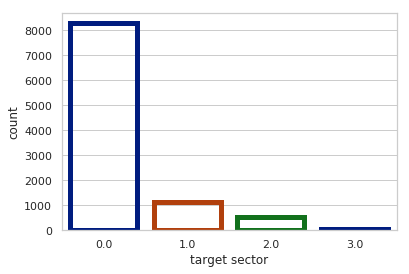

In [13]:
cplot('target sector')

almost 90% of text is non-toxic , now how about the toxic texts , lets temporarly drop all non-toxic text , to see distribution of ther categories

In [14]:
temp_data = data[data['target sector'] > 0]['target sector']

now to pie chart it

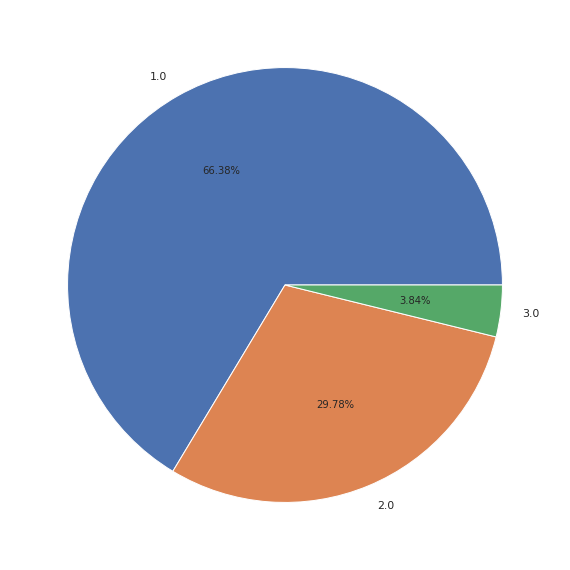

In [15]:
plt.figure(figsize=(10,10))
plt.pie(temp_data.value_counts(),labels=list(temp_data.value_counts().index),autopct ='%1.2f%%',labeldistance = 1.1)
plt.show()

almost two-third of text are kinda toxic , then moderate & little bit which is very toxic

now how about nulls in the database 

In [16]:
count_nulls()

Column   asian    got   7824 nulls  ,  Percentage : 78.0 %
Column   atheist    got   7824 nulls  ,  Percentage : 78.0 %
Column   bisexual    got   7824 nulls  ,  Percentage : 78.0 %
Column   black    got   7824 nulls  ,  Percentage : 78.0 %
Column   buddhist    got   7824 nulls  ,  Percentage : 78.0 %
Column   christian    got   7824 nulls  ,  Percentage : 78.0 %
Column   female    got   7824 nulls  ,  Percentage : 78.0 %
Column   heterosexual    got   7824 nulls  ,  Percentage : 78.0 %
Column   hindu    got   7824 nulls  ,  Percentage : 78.0 %
Column   homosexual_gay_or_lesbian    got   7824 nulls  ,  Percentage : 78.0 %
Column   intellectual_or_learning_disability    got   7824 nulls  ,  Percentage : 78.0 %
Column   jewish    got   7824 nulls  ,  Percentage : 78.0 %
Column   latino    got   7824 nulls  ,  Percentage : 78.0 %
Column   male    got   7824 nulls  ,  Percentage : 78.0 %
Column   muslim    got   7824 nulls  ,  Percentage : 78.0 %
Column   other_disability    got   7824 nul

_____

# Treating Text

now it's time to focus in text its self before we build the model 

first we need to lowercase all words , to avoid any misleading in training

In [17]:
data['comments']  =  data['comment_text'].str.lower()

now how it looks like

In [18]:
SlicedData(['comment_text' , 'comments']).head(20)

,comment_text,comments
0,"This is so cool. It's like, 'would you want yo...","this is so cool. it's like, 'would you want yo..."
1,Thank you!! This would make my life a lot less...,thank you!! this would make my life a lot less...
2,This is such an urgent design problem; kudos t...,this is such an urgent design problem; kudos t...
3,Is this something I'll be able to install on m...,is this something i'll be able to install on m...
4,haha you guys are a bunch of losers.,haha you guys are a bunch of losers.
5,ur a sh*tty comment.,ur a sh*tty comment.
6,hahahahahahahahhha suck it.,hahahahahahahahhha suck it.
7,FFFFUUUUUUUUUUUUUUU,ffffuuuuuuuuuuuuuuu
8,The ranchers seem motivated by mostly by greed...,the ranchers seem motivated by mostly by greed...
9,It was a great show. Not a combo I'd of expect...,it was a great show. not a combo i'd of expect...


then we need to know the number of total words & unique words in the whole text 

In [19]:
CountWords(data['comments'])

Total words are 608328 words

Total unique words are 54731 words


_____

almost a 600K word in only 10K row , which based on 54K unqiue words

now we need to know most common words in the whole text , & we'll use the feature 'comments' , which is lowered case , not the original feature 'comment_text'

In [20]:
common = CommonWords(data['comments'])

The word is   people   repeated   1879  times
The word is   like   repeated   1681  times
The word is   it's   repeated   1372  times
The word is   don't   repeated   1323  times
The word is   think   repeated   1077  times
The word is   know   repeated   812  times
The word is   -   repeated   762  times
The word is   i'm   repeated   751  times
The word is   good   repeated   742  times
The word is   time   repeated   718  times


it looks like these 10 words are non-leading words , which might appear in toxic or non-toxic words , so it'll be a good idea to remove it from all phrases , to ust leave the most important words

let's create a new feature called 'filtered comments' , which contain all phrases exclude these common words

In [21]:
RemoveWords(data , 'comments' , 'filtered comments', common)
SlicedData(['comments' , 'filtered comments']).head(20)

,comments,filtered comments
0,"this is so cool. it's like, 'would you want yo...","this is so cool. like, 'would you want your mo..."
1,thank you!! this would make my life a lot less...,thank you!! this would make my life a lot less...
2,this is such an urgent design problem; kudos t...,this is such an urgent design problem; kudos t...
3,is this something i'll be able to install on m...,is this something i'll be able to install on m...
4,haha you guys are a bunch of losers.,haha you guys are a bunch of losers.
5,ur a sh*tty comment.,ur a sh*tty comment.
6,hahahahahahahahhha suck it.,hahahahahahahahhha suck it.
7,ffffuuuuuuuuuuuuuuu,ffffuuuuuuuuuuuuuuu
8,the ranchers seem motivated by mostly by greed...,the ranchers seem motivated by mostly by greed...
9,it was a great show. not a combo i'd of expect...,it was a great show. not a combo i'd of expect...


great , now phrases become more extinctive 

_____

# Cloud Words

it's useful to use wordcloud tool , to know most repeated words 

let's see most repeated words now in all filtered comments , after we eliminate those 10 common words

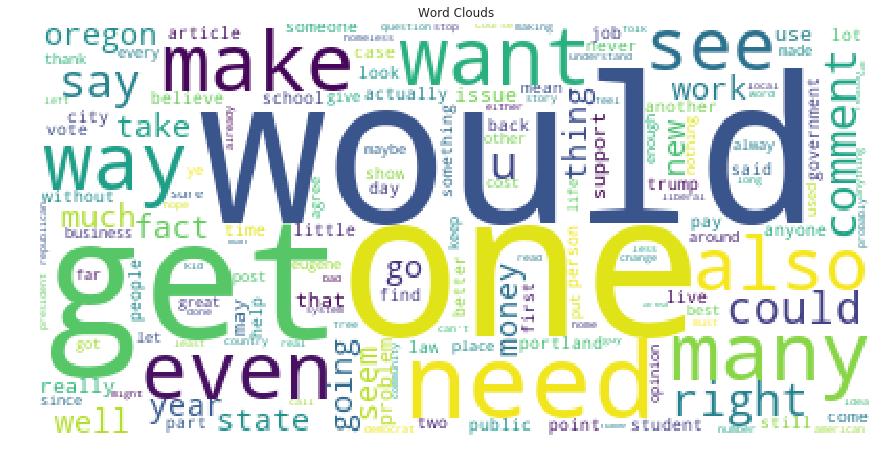

In [22]:
MakeCloud(data['filtered comments'])

how about to see the could words for each category . . 

we'll make a function now , which will show cloud words for only rows which got offensive value more than 0.1 in each category , of the 24 category we have here 

& to make it easier for us to read it , we'll show it 3 by 3 


In [23]:
def showclouds(n) : 
    this_list = ['asian', 'atheist', 'bisexual','black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
                 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability','jewish', 'latino', 'male', 'muslim',
                 'other_disability','other_gender', 'other_race_or_ethnicity', 'other_religion','other_sexual_orientation', 
                 'physical_disability','psychiatric_or_mental_illness', 'transgender', 'white' ]

    for item in this_list[n*3:(n*3)+3] : 
        this_data =  SelectedData(data ,item , 0.1 , 1 , 'filtered comments')
        print(f'for item    {item}')
        print(f'Number of selected rows {this_data.shape[0]}')
        print('common words : ')
        _ = CommonWords(this_data)
        if this_data.shape[0] >0 : 
            MakeCloud(this_data , str(f'Word Cloud for {item}'), 8 ,8)
        print('--------------------------')

____


now start with :   'asian', 'atheist', 'bisexual'

for item    asian
Number of selected rows 27
common words : 
The word is   ,   repeated   10  times
The word is   use   repeated   7  times
The word is   chinese   repeated   7  times
The word is   trump   repeated   6  times
The word is   going   repeated   5  times
The word is   white   repeated   5  times
The word is   understand   repeated   5  times
The word is   found   repeated   5  times
The word is   species   repeated   5  times
The word is   sounds   repeated   4  times


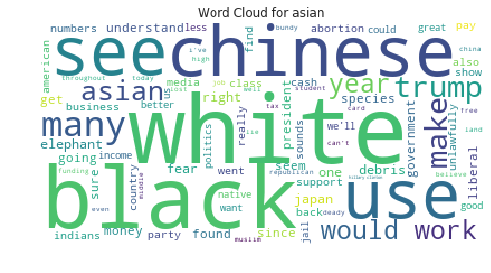

--------------------------
for item    atheist
Number of selected rows 25
common words : 
The word is   atheist   repeated   12  times
The word is   church   repeated   10  times
The word is   imago   repeated   7  times
The word is   regular   repeated   7  times
The word is   dei   repeated   6  times
The word is   churches   repeated   6  times
The word is   find   repeated   5  times
The word is   portland   repeated   5  times
The word is   religious   repeated   5  times
The word is   big   repeated   5  times


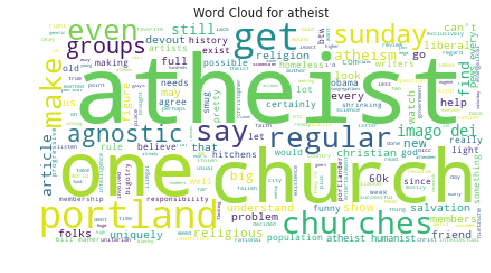

--------------------------
for item    bisexual
Number of selected rows 24
common words : 
The word is   church   repeated   15  times
The word is   lgbtq   repeated   9  times
The word is   women   repeated   9  times
The word is   evangelical   repeated   7  times
The word is   lgbt   repeated   7  times
The word is   imago   repeated   7  times
The word is   can't   repeated   6  times
The word is   jules   repeated   6  times
The word is   believe   repeated   6  times
The word is   conservative   repeated   6  times


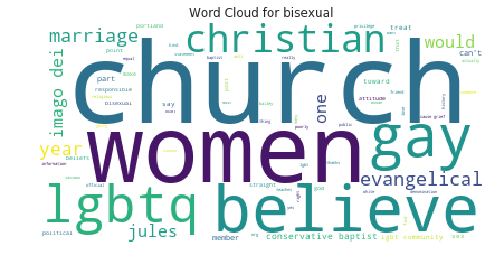

--------------------------


In [24]:
showclouds(0)

_______

then :'black', 'buddhist', 'christian'

for item    black
Number of selected rows 133
common words : 
The word is   black   repeated   96  times
The word is   white   repeated   53  times
The word is   lives   repeated   20  times
The word is   you're   repeated   19  times
The word is   police   repeated   19  times
The word is   use   repeated   18  times
The word is   .   repeated   18  times
The word is   support   repeated   18  times
The word is   far   repeated   17  times
The word is   mr.   repeated   17  times


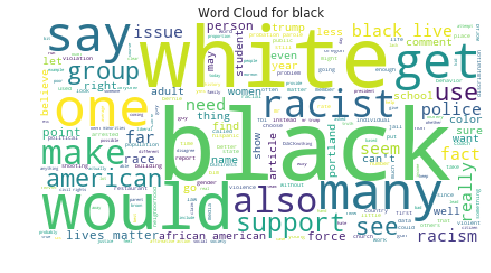

--------------------------
for item    buddhist
Number of selected rows 1
common words : 
The word is   attempt   repeated   1  times
The word is   smear   repeated   1  times
The word is   christianity   repeated   1  times
The word is   comparing   repeated   1  times
The word is   radical   repeated   1  times
The word is   islam   repeated   1  times
The word is   duly   repeated   1  times
The word is   noted.   repeated   1  times
The word is   illogic   repeated   1  times
The word is   applied   repeated   1  times


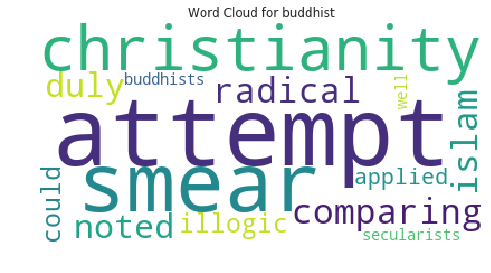

--------------------------
for item    christian
Number of selected rows 222
common words : 
The word is   church   repeated   113  times
The word is   imago   repeated   70  times
The word is   dei   repeated   51  times
The word is   christian   repeated   46  times
The word is   conservative   repeated   42  times
The word is   women   repeated   39  times
The word is   believe   repeated   30  times
The word is   bailey   repeated   30  times
The word is   jules   repeated   28  times
The word is   baptist   repeated   27  times


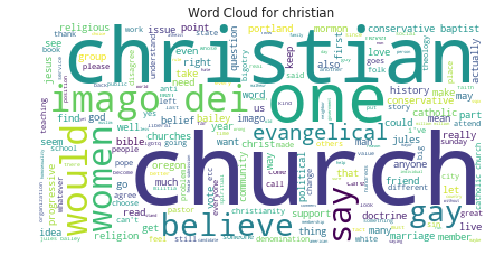

--------------------------


In [25]:
showclouds(1)

_____

then :  'female', 'heterosexual', 'hindu'

for item    female
Number of selected rows 410
common words : 
The word is   women   repeated   175  times
The word is   woman   repeated   84  times
The word is   church   repeated   56  times
The word is   men   repeated   51  times
The word is   support   repeated   43  times
The word is   need   repeated   42  times
The word is   female   repeated   39  times
The word is   doesn't   repeated   38  times
The word is   want   repeated   37  times
The word is   right   repeated   36  times


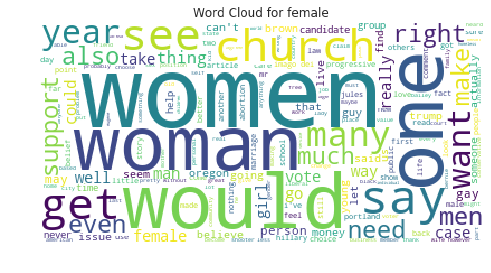

--------------------------
for item    heterosexual
Number of selected rows 25
common words : 
The word is   gay   repeated   13  times
The word is   marriage   repeated   11  times
The word is   straight   repeated   9  times
The word is   believe   repeated   9  times
The word is   conservative   repeated   8  times
The word is   imago   repeated   7  times
The word is   women   repeated   7  times
The word is   support   repeated   7  times
The word is   better   repeated   6  times
The word is   political   repeated   6  times


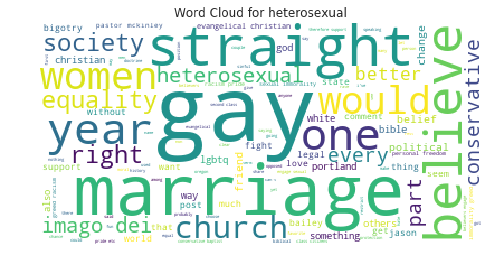

--------------------------
for item    hindu
Number of selected rows 0
common words : 
--------------------------


In [26]:
showclouds(2)

______

now : 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability','jewish'

for item    homosexual_gay_or_lesbian
Number of selected rows 137
common words : 
The word is   church   repeated   67  times
The word is   gay   repeated   56  times
The word is   imago   repeated   49  times
The word is   marriage   repeated   34  times
The word is   bailey   repeated   33  times
The word is   dei   repeated   33  times
The word is   jules   repeated   33  times
The word is   believe   repeated   30  times
The word is   support   repeated   27  times
The word is   women   repeated   26  times


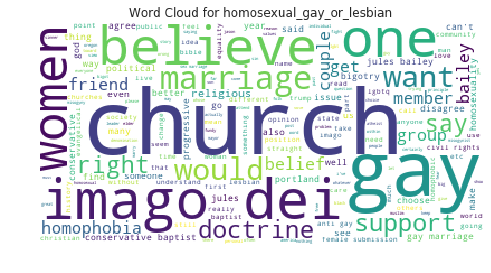

--------------------------
for item    intellectual_or_learning_disability
Number of selected rows 16
common words : 
The word is   school   repeated   7  times
The word is   need   repeated   6  times
The word is   special   repeated   6  times
The word is   social   repeated   5  times
The word is   ed   repeated   5  times
The word is   child   repeated   4  times
The word is   kids   repeated   4  times
The word is   mentally   repeated   4  times
The word is   shameless   repeated   4  times
The word is   them.   repeated   3  times


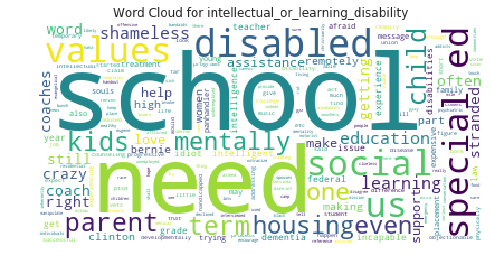

--------------------------
for item    jewish
Number of selected rows 31
common words : 
The word is   israel   repeated   18  times
The word is   jewish   repeated   18  times
The word is   state   repeated   11  times
The word is   south   repeated   11  times
The word is   palestinian   repeated   9  times
The word is   israeli   repeated   8  times
The word is   white   repeated   7  times
The word is   arab   repeated   6  times
The word is   mr.   repeated   6  times
The word is   african   repeated   5  times


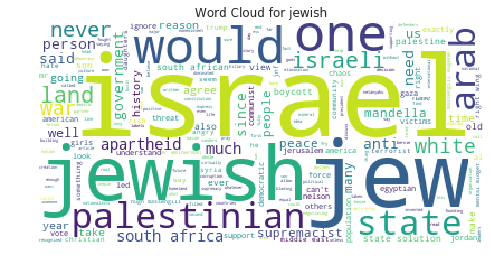

--------------------------


In [27]:
showclouds(3)

______

now  :  'latino', 'male', 'muslim'

for item    latino
Number of selected rows 29
common words : 
The word is   trump   repeated   14  times
The word is   white   repeated   9  times
The word is   racism   repeated   7  times
The word is   spanish   repeated   6  times
The word is   asi   repeated   6  times
The word is   program   repeated   6  times
The word is   poor   repeated   5  times
The word is   blacks   repeated   5  times
The word is   fact   repeated   5  times
The word is   black   repeated   5  times


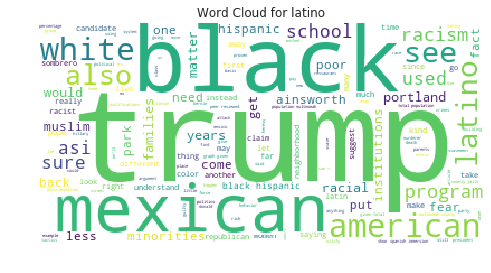

--------------------------
for item    male
Number of selected rows 395
common words : 
The word is   women   repeated   86  times
The word is   men   repeated   76  times
The word is   man   repeated   72  times
The word is   white   repeated   52  times
The word is   male   repeated   40  times
The word is   years   repeated   34  times
The word is   want   repeated   33  times
The word is   doesn't   repeated   33  times
The word is   woman   repeated   32  times
The word is   church   repeated   32  times


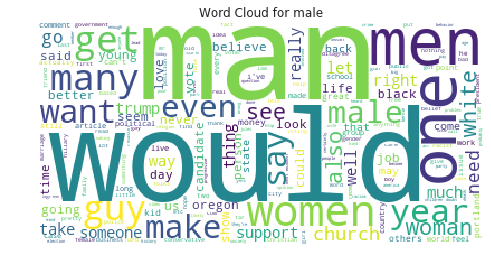

--------------------------
for item    muslim
Number of selected rows 43
common words : 
The word is   muslim   repeated   22  times
The word is   saudi   repeated   10  times
The word is   can't   repeated   9  times
The word is   law   repeated   9  times
The word is   trump   repeated   9  times
The word is   religious   repeated   9  times
The word is   malheur   repeated   8  times
The word is   muslims   repeated   7  times
The word is   extremists   repeated   7  times
The word is   reason   repeated   7  times


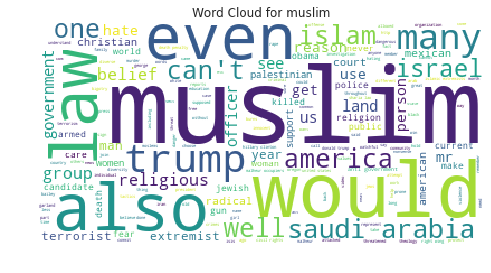

--------------------------


In [28]:
showclouds(4)

_____

then : 'other_disability','other_gender', 'other_race_or_ethnicity'

for item    other_disability
Number of selected rows 9
common words : 
The word is   health   repeated   5  times
The word is   million   repeated   5  times
The word is   women   repeated   4  times
The word is   $48   repeated   4  times
The word is   impact   repeated   3  times
The word is   individual   repeated   3  times
The word is   cdc   repeated   2  times
The word is   giving   repeated   2  times
The word is   harm   repeated   2  times
The word is   known   repeated   2  times


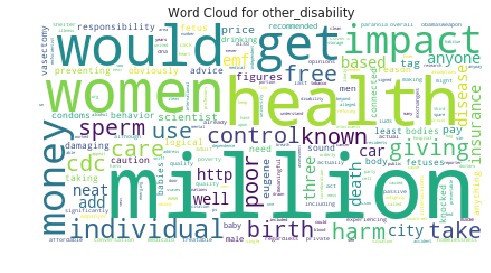

--------------------------
for item    other_gender
Number of selected rows 5
common words : 
The word is   believe   repeated   2  times
The word is   judge   repeated   2  times
The word is   university   repeated   2  times
The word is   listeners   repeated   2  times
The word is   kwax   repeated   2  times
The word is   let's   repeated   1  times
The word is   thing   repeated   1  times
The word is   clear.   repeated   1  times
The word is   (i   repeated   1  times
The word is   presume)   repeated   1  times


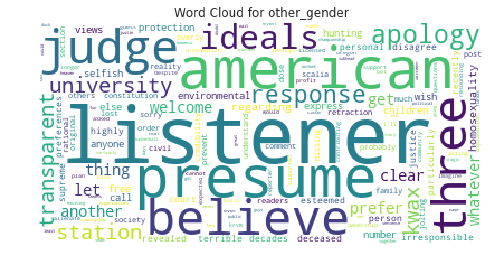

--------------------------
for item    other_race_or_ethnicity
Number of selected rows 39
common words : 
The word is   israel   repeated   9  times
The word is   white   repeated   8  times
The word is   american   repeated   6  times
The word is   well,   repeated   6  times
The word is   black   repeated   6  times
The word is   believe   repeated   6  times
The word is   arab   repeated   6  times
The word is   indians   repeated   6  times
The word is   going   repeated   5  times
The word is   war   repeated   5  times


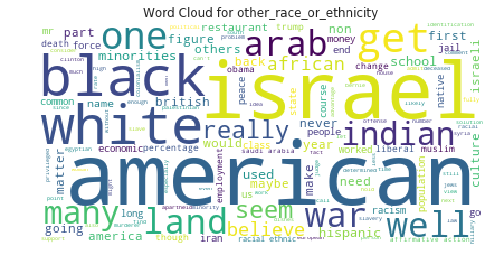

--------------------------


In [29]:
showclouds(5)

______

then : 'other_religion','other_sexual_orientation'  ,'physical_disability'

for item    other_religion
Number of selected rows 47
common words : 
The word is   church   repeated   15  times
The word is   mormon   repeated   12  times
The word is   religious   repeated   11  times
The word is   conservative   repeated   10  times
The word is   .   repeated   10  times
The word is   women   repeated   9  times
The word is   dei   repeated   8  times
The word is   southern   repeated   7  times
The word is   catholic   repeated   7  times
The word is   imago   repeated   7  times


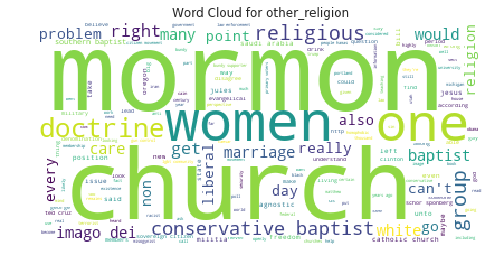

--------------------------
for item    other_sexual_orientation
Number of selected rows 7
common words : 
The word is   public   repeated   5  times
The word is   church   repeated   4  times
The word is   lives   repeated   3  times
The word is   gay   repeated   3  times
The word is   conservative   repeated   3  times
The word is   sex   repeated   3  times
The word is   nra   repeated   3  times
The word is   black   repeated   2  times
The word is   person   repeated   2  times
The word is   going   repeated   2  times


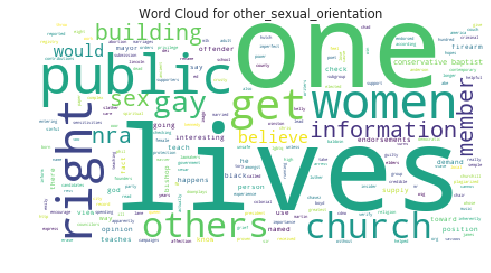

--------------------------
for item    physical_disability
Number of selected rows 13
common words : 
The word is   help   repeated   7  times
The word is   physically   repeated   6  times
The word is   need   repeated   6  times
The word is   disabled,   repeated   5  times
The word is   getting   repeated   5  times
The word is   services   repeated   4  times
The word is   legislation   repeated   3  times
The word is   treatment   repeated   3  times
The word is   understand   repeated   3  times
The word is   rent   repeated   3  times


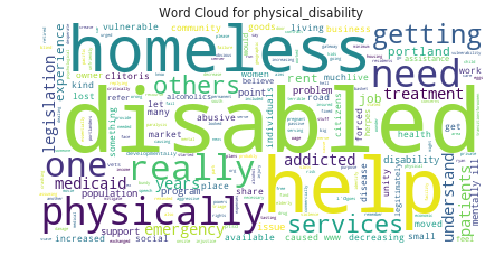

--------------------------


In [30]:
showclouds(6)

____

and last : 'psychiatric_or_mental_illness', 'transgender', 'white'

for item    psychiatric_or_mental_illness
Number of selected rows 98
common words : 
The word is   mental   repeated   52  times
The word is   mentally   repeated   44  times
The word is   need   repeated   31  times
The word is   ill   repeated   22  times
The word is   help   repeated   19  times
The word is   illness   repeated   19  times
The word is   support   repeated   19  times
The word is   state   repeated   18  times
The word is   oregon   repeated   17  times
The word is   individuals   repeated   17  times


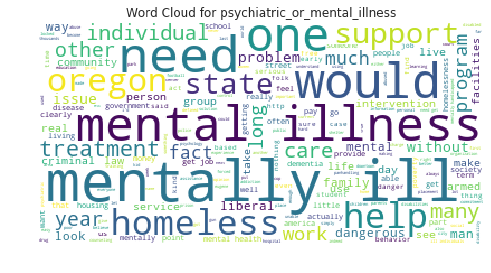

--------------------------
for item    transgender
Number of selected rows 19
common words : 
The word is   church   repeated   9  times
The word is   women   repeated   8  times
The word is   gay   repeated   8  times
The word is   lgbtq   repeated   8  times
The word is   evangelical   repeated   7  times
The word is   conservative   repeated   7  times
The word is   community   repeated   6  times
The word is   imago   repeated   6  times
The word is   couples   repeated   5  times
The word is   members   repeated   5  times


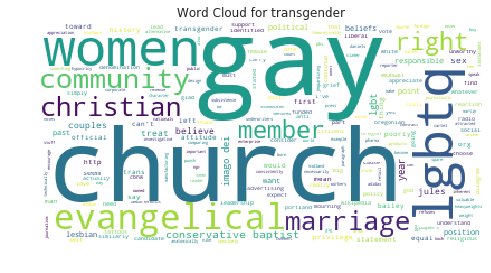

--------------------------
for item    white
Number of selected rows 158
common words : 
The word is   white   repeated   138  times
The word is   black   repeated   50  times
The word is   support   repeated   23  times
The word is   right   repeated   20  times
The word is   point   repeated   19  times
The word is   use   repeated   18  times
The word is   want   repeated   18  times
The word is   trump   repeated   18  times
The word is   political   repeated   17  times
The word is   women   repeated   17  times


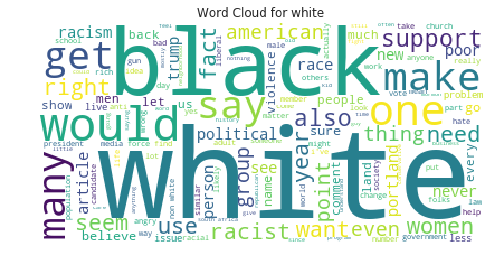

--------------------------


In [31]:
showclouds(7)

it was so obvious how distinctive words are appear in each category , & that will help us in the classification

_____

# Data Preparing

now we are ready to define X & y 

In [32]:
X = data['filtered comments']
y = data['target sector']

how X looks like ? 

In [33]:
X.head(10)

0    this is so cool. like, 'would you want your mo...
1    thank you!! this would make my life a lot less...
2    this is such an urgent design problem; kudos t...
3    is this something i'll be able to install on m...
4                 haha you guys are a bunch of losers.
5                                 ur a sh*tty comment.
6                          hahahahahahahahhha suck it.
7                                  ffffuuuuuuuuuuuuuuu
8    the ranchers seem motivated by mostly by greed...
9    it was a great show. not a combo i'd of expect...
Name: filtered comments, dtype: object

& y ? 

In [34]:
y.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    3.0
5    2.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: target sector, dtype: float64

we need to be sure there is no nulls in both of them 

In [35]:
X.isnull().sum() , y.isnull().sum()

(0, 0)

then we'll use TF Vectorizer tool , to create sparse matrix for all words

In [36]:
VecModel = TfidfVectorizer()
X = VecModel.fit_transform(X)
print(f'The new shape for X is {X.shape}')

The new shape for X is (10000, 25644)


ok , almost 25K feature , which is so much & will consume a huge amount of time , specially that we have 10K sample size , so we'll use sklearn to only select 1% of those features

In [37]:
FeatureSelection = SelectPercentile(score_func = f_classif, percentile=1)
X = FeatureSelection.fit_transform(X, y)

now how X looks like

In [38]:
print('X Shape is ' , X.shape)

X Shape is  (10000, 257)


great , then split them 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44, shuffle =True)

print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (6700, 257)
X_test shape is  (3300, 257)
y_train shape is  (6700,)
y_test shape is  (3300,)


now we are ready for traning

_____

# Build the Model

let's use GBC since it's more suitable for big amout of data . 

we'll use 500 estimators with max_depth =5

let's start the train & check accuracy for train & test data

In [40]:
GBCModel = GradientBoostingClassifier(n_estimators=500,max_depth=5,random_state=33) 
GBCModel.fit(X_train, y_train)


print('GBCModel Train Score is : ' , GBCModel.score(X_train, y_train))
print('GBCModel Test Score is : ' , GBCModel.score(X_test, y_test))


GBCModel Train Score is :  0.9482089552238806
GBCModel Test Score is :  0.8427272727272728


ok 84% is not a bad accuracy , might be better if we increase the data more than 100K but it will need more time

now let's predict the Test Data. . 

In [41]:
test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


let's lower case it as we did in trainging data

In [42]:
test['comments']  =  test['comment_text'].str.lower()
test.head()

,id,comment_text,comments
0,7097320,[ Integrity means that you pay your debts.]\n\...,[ integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...,this is malfeasance by the administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,@rmiller101 - spoken like a true elitist. but ...
3,7097323,"Paul: Thank you for your kind words. I do, in...","paul: thank you for your kind words. i do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...,sorry you missed high school. eisenhower sent ...


and put it in the variable X_test

In [43]:
X_test = test['comments']

what is the shape 

In [44]:
X_test.shape

(97320,)

then we have to transform it with the Vectorize Model , which fitted in the training data

In [45]:
X_test = VecModel.transform(X_test)

the data now should have 25K feature


In [46]:
X_test.shape

(97320, 25644)

erfect , now we have to apply again the feature selection model , to only pick 1% of same features 

In [47]:
X_test = FeatureSelection.transform(X_test)

now it should have only 257 feature

In [48]:
X_test.shape

(97320, 257)

now it's ready for predicting using the same GBC Model

In [49]:
y_pred = GBCModel.predict(X_test)
y_pred_prob = GBCModel.predict_proba(X_test)
print('Predicted Value for GBCModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for GBCModel is : ' , y_pred_prob[:10])

Predicted Value for GBCModel is :  [0. 0. 1. 0. 0. 0. 3. 1. 0. 0.]
Prediction Probabilities Value for GBCModel is :  [[9.66739654e-01 1.72934903e-02 1.59472438e-02 1.96115696e-05]
 [9.32524712e-01 5.79898146e-02 9.48234788e-03 3.12580348e-06]
 [4.59417557e-02 9.40109921e-01 1.39457463e-02 2.57694460e-06]
 [6.17842704e-01 1.61719830e-01 2.20433992e-01 3.47356068e-06]
 [9.61687442e-01 3.10047069e-02 7.30390224e-03 3.94833054e-06]
 [9.26373976e-01 6.10134807e-02 1.26071534e-02 5.38997951e-06]
 [3.56174239e-04 1.86807804e-05 5.39585700e-05 9.99571186e-01]
 [4.72661527e-01 4.79878072e-01 4.74497894e-02 1.06117777e-05]
 [9.32483191e-01 4.99167301e-02 1.63502717e-02 1.24980747e-03]
 [9.17431914e-01 7.18676149e-02 1.06957038e-02 4.76741422e-06]]


great , well done !

hope you like it & found it useful . . 